In [39]:
import numpy as np
import pandas as pd
import datetime
import tqdm

In [172]:
df = pd.read_csv('dataset/Bitstamp_BTCUSD_1h.csv',
                 index_col='date',
                 parse_dates=['date'])

df.sort_index(inplace=True)
# df = df.loc['2019-06-01':]
df

,open,high,low,close
date,,,,
2018-05-15 06:00:00,8733.86,8796.68,8707.28,8740.99
2018-05-15 07:00:00,8740.99,8766.00,8721.11,8739.00
2018-05-15 08:00:00,8739.00,8750.27,8660.53,8728.49
2018-05-15 09:00:00,8728.49,8754.40,8701.35,8708.32
2018-05-15 10:00:00,8708.32,8865.00,8695.11,8795.90
...,...,...,...,...
2021-08-27 20:00:00,48332.44,49187.00,48188.88,48950.41
2021-08-27 21:00:00,48995.23,49089.58,48889.00,49005.09
2021-08-27 22:00:00,48999.57,49069.38,48725.00,49014.60


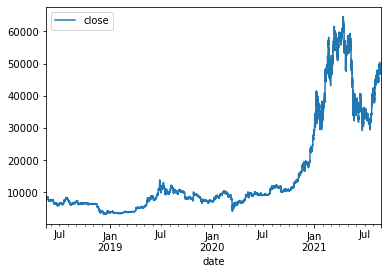

In [173]:
df.plot(y='close')

In [174]:
CAPITAL = 1000

## Buy & Hold BTC

In [175]:
buy_and_hold_df = df[['open', 'high', 'low', 'close']]

In [176]:
price = buy_and_hold_df['close'].iloc[0]
position_size = CAPITAL / price
buy_and_hold_df['nav'] = buy_and_hold_df['close'] * position_size

In [177]:
buy_and_hold_df

,open,high,low,close,nav
date,,,,,
2018-05-15 06:00:00,8733.86,8796.68,8707.28,8740.99,1000.000000
2018-05-15 07:00:00,8740.99,8766.00,8721.11,8739.00,999.772337
2018-05-15 08:00:00,8739.00,8750.27,8660.53,8728.49,998.569956
2018-05-15 09:00:00,8728.49,8754.40,8701.35,8708.32,996.262437
2018-05-15 10:00:00,8708.32,8865.00,8695.11,8795.90,1006.281897
...,...,...,...,...,...
2021-08-27 20:00:00,48332.44,49187.00,48188.88,48950.41,5600.099073
2021-08-27 21:00:00,48995.23,49089.58,48889.00,49005.09,5606.354658
2021-08-27 22:00:00,48999.57,49069.38,48725.00,49014.60,5607.442635


## Time-based Rebalancing

In [178]:
def ohlc_resampler(df):

    if len(df) == 0:
        return pd.Series({
            'open': np.NaN,
            'high': np.NaN,
            'low': np.NaN,
            'close':np.NaN
        })
    return pd.Series({
        'open': df.loc[df.index.min(), 'open'],
        'high': df['high'].max(),
        'low': df['low'].min(),
        'close': df.loc[df.index.max(), 'close']
    })
def resample_ohlc(asset_df, timeframe):
    return asset_df.groupby(pd.Grouper(freq=timeframe)).apply(ohlc_resampler)

In [179]:
def time_rebalance(df, asset_ratio, capital, timeframe='1d'):
    
    cash_ratio = 1 - asset_ratio

    price_df = df.copy()
    rebalance_df = pd.DataFrame(index=df.index).asfreq(freq=timeframe)
    # init
    init_index = rebalance_df.index[0]
    init_asset_value = capital * asset_ratio
    init_asset_amount = init_asset_value / price_df.loc[init_index, 'close']
    init_cash = capital * cash_ratio

    rebalance_df.loc[init_index, 'nav'] = capital
    rebalance_df.loc[init_index, 'asset_value'] = init_asset_value
    rebalance_df.loc[init_index, 'asset_amount'] = init_asset_amount
    rebalance_df.loc[init_index, 'cash'] = capital * cash_ratio


    original_asset_value = init_asset_value
    original_asset_amount = init_asset_amount
    original_cash = init_cash

    for index in rebalance_df.index:

        price = price_df.at[index, 'close']

        # Update asset price / value

        original_asset_value = original_asset_amount * price
        original_nav = original_asset_value + original_cash

        # Calculate rebalancing

        rebalanced_asset_value = original_nav * asset_ratio
        diff_asset_value = rebalanced_asset_value - original_asset_value
        diff_asset_amount = diff_asset_value / price
        rebalanced_cash = original_cash - diff_asset_value
        rebalanced_asset_amount = original_asset_amount + diff_asset_amount
        rebalanced_nav = rebalanced_asset_value + rebalanced_cash


        action = 'Buy' if diff_asset_value >= 0 else 'Sell'

        # add to dataframe

        rebalance_df.at[index, 'asset_value'] = original_asset_value
        rebalance_df.at[index, 'asset_amount'] = original_asset_amount
        rebalance_df.at[index, 'cash'] = original_cash
        rebalance_df.at[index, 'nav'] = original_nav

        rebalance_df.at[index, 'diff_asset_value'] = diff_asset_value
        rebalance_df.at[index, 'action'] = action

        rebalance_df.at[index, 're_asset_value'] = rebalanced_asset_value
        rebalance_df.at[index, 're_asset_amount'] = rebalanced_asset_amount
        rebalance_df.at[index, 're_cash'] = rebalanced_cash
        rebalance_df.at[index, 're_nav'] = rebalanced_nav


        # Update original value / nav

        original_asset_amount = rebalanced_asset_amount
        original_cash = rebalanced_cash
    # Merge to price_df
    price_df = price_df.merge(rebalance_df, how='left', left_index=True, right_index=True)
    price_df[['asset_amount', 'cash']] = price_df[['asset_amount', 'cash']].ffill()
    price_df['asset_value'] = price_df['asset_amount'] * price_df['close']
    price_df['nav'] = price_df['asset_value'] + price_df['cash']
    
    return price_df, rebalance_df

In [180]:
re_price_df, rebalance_df = time_rebalance(df, asset_ratio=0.5, capital=CAPITAL)

100%|██████████| 9/9 [00:00<00:00,  9.36it/s]


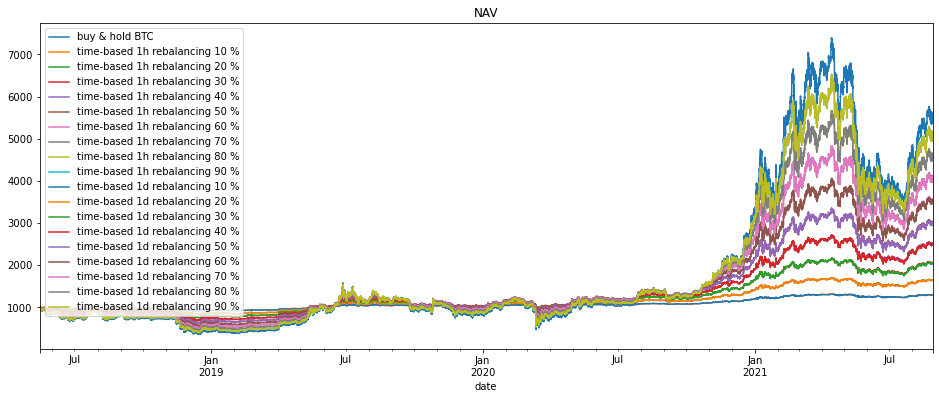

In [181]:
comparison_df = pd.DataFrame(data={
                                'buy & hold BTC': buy_and_hold_df['nav']
                            },
                            index=df.index)
for asset_ratio in tqdm.tqdm(np.arange(0.1, 1.0, 0.1)):
    re_price_df, rebalance_df = time_rebalance(df, asset_ratio=asset_ratio, capital=CAPITAL, timeframe='1h')
    comparison_df[f'time-based 1h rebalancing {int(asset_ratio*100)} %'] = re_price_df['nav']
for asset_ratio in tqdm.tqdm(np.arange(0.1, 1.0, 0.1)):
    re_price_df, rebalance_df = time_rebalance(df, asset_ratio=asset_ratio, capital=CAPITAL, timeframe='1d')
    comparison_df[f'time-based 1d rebalancing {int(asset_ratio*100)} %'] = re_price_df['nav']
comparison_df.plot(figsize=(16, 6), title='NAV')

In [182]:
def expected_return(prices, risk_free_rate):
    return (prices.pct_change() - risk_free_rate).mean() 
def volatility(prices):
    return prices.pct_change().std()
def sharpe_ratio(prices, risk_free_rate):
    return expected_return(prices, risk_free_rate) / volatility(prices)

In [197]:
# rebalance_comparison_df = comparison_df.filter(regex='.*rebalancing.*')
rebalance_comparison_df = comparison_df.resample('1d').first()
efficient_frontier_df = pd.DataFrame(data={
    'return': rebalance_comparison_df.apply(expected_return, risk_free_rate=0.00),
    'volatility': rebalance_comparison_df.apply(volatility),
    'sharpe': rebalance_comparison_df.apply(sharpe_ratio, risk_free_rate=0.00),
})

In [198]:
efficient_frontier_df.style.background_gradient(axis=0,)


,return,volatility,sharpe
buy & hold BTC,0.002312,0.041378,0.055864
time-based 1h rebalancing 10 %,0.000227,0.004193,0.054097
time-based 1h rebalancing 20 %,0.000455,0.008372,0.054322
time-based 1h rebalancing 30 %,0.000684,0.012537,0.054540
time-based 1h rebalancing 40 %,0.000914,0.016688,0.054750
time-based 1h rebalancing 50 %,0.001145,0.020828,0.054953
time-based 1h rebalancing 60 %,0.001376,0.024956,0.055149
time-based 1h rebalancing 70 %,0.001609,0.029075,0.055338
time-based 1h rebalancing 80 %,0.001842,0.033184,0.055520
time-based 1h rebalancing 90 %,0.002077,0.037284,0.055695


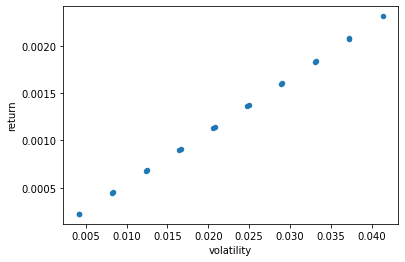

In [199]:
efficient_frontier_df.plot.scatter(x='volatility', y='return')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x149bdb850>,
      dtype=object)

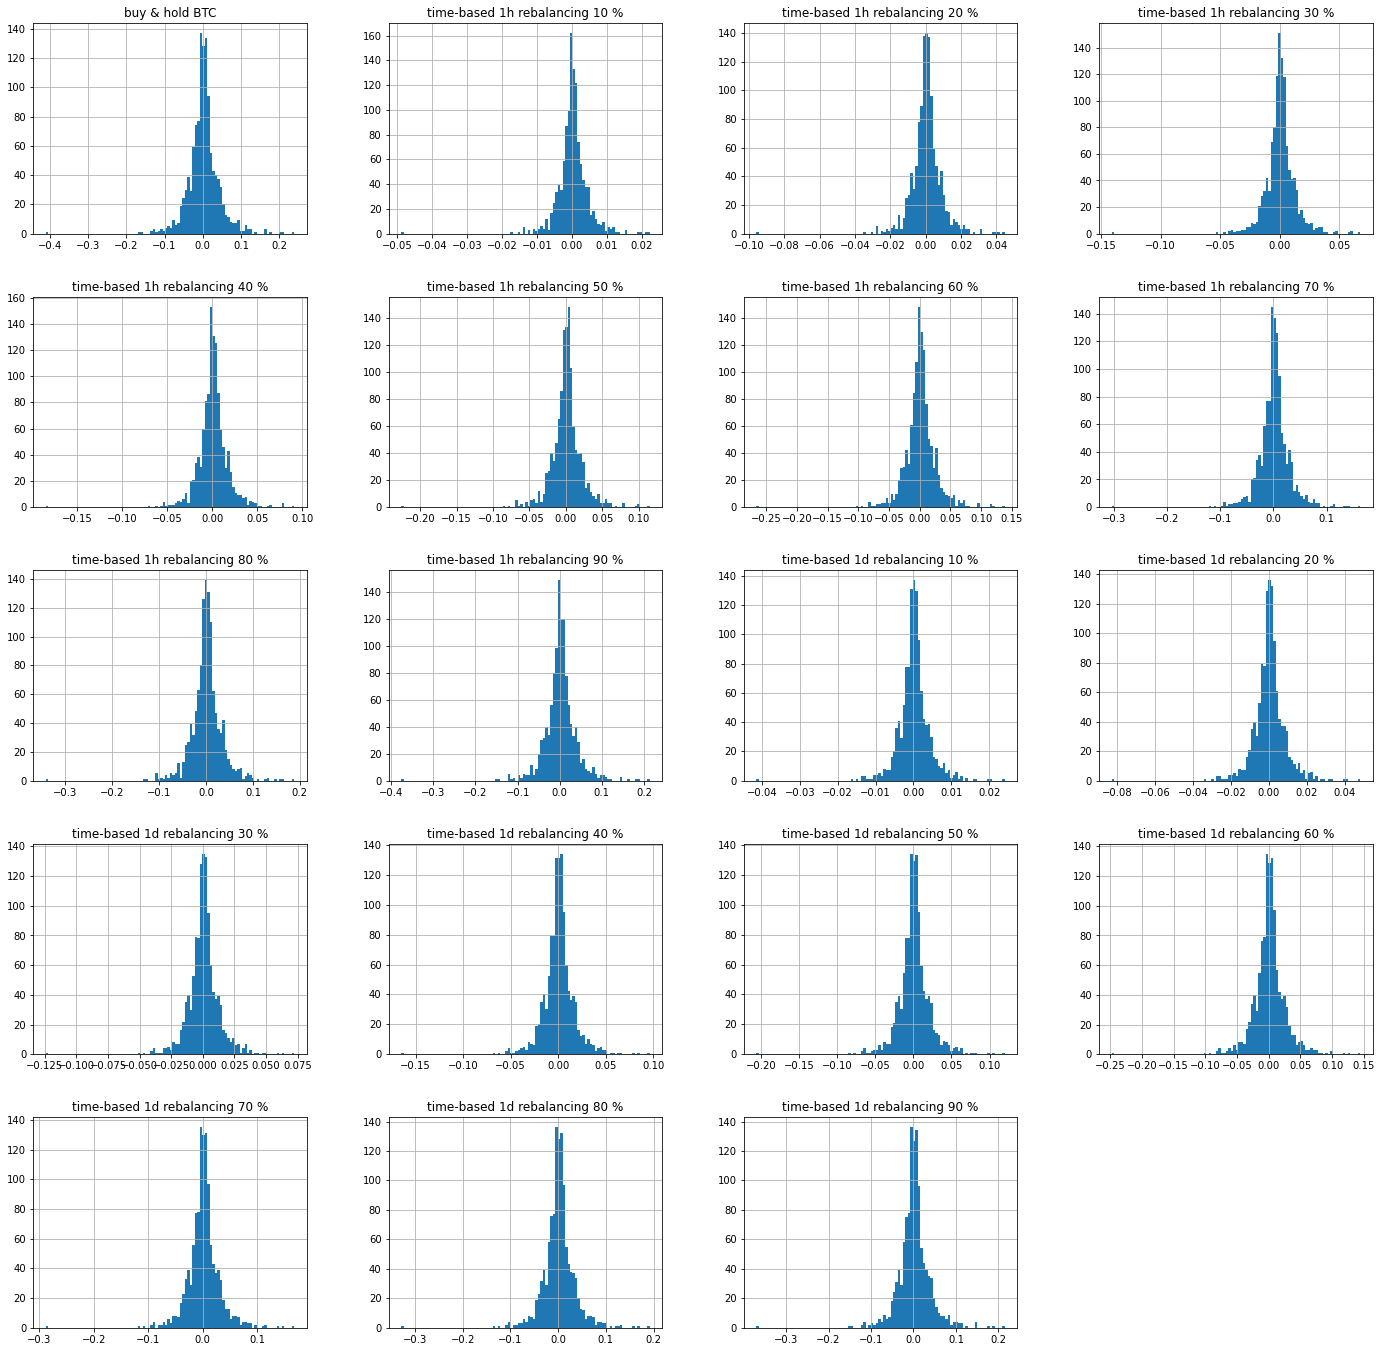

In [200]:
rebalance_comparison_df.apply(lambda prices: prices.pct_change()).hist(figsize=(24, 24), bins=100)